# Spooky Author Identification: GloVe CNN Model

## Implementation

### Import packages

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from packages import *

Using TensorFlow backend.


In [146]:
MODEL_NAME = 'glove_cnn'

INPUT_DIR = '../input/'
TRAIN_FILE_PATH = f'{INPUT_DIR}train.csv'
TEST_FILE_PATH = f'{INPUT_DIR}test.csv'
SAMPLE_SUBMISSION_FILE_PATH = f'{INPUT_DIR}sample_submission.csv'

SUBMISSIONS_DIR = '../submissions/'

EMBEDDINGS_DIR = f'{INPUT_DIR}embeddings/'
EMBEDDINGS_FILE_PATH = f'{EMBEDDINGS_DIR}glove.840B.300d.txt'

OUTPUT_DIR = '../output/'
OUTPUT_LOGS_DIR = f'{OUTPUT_DIR}{MODEL_NAME}/logs/'
OUTPUT_MODELS_DIR = f'{OUTPUT_DIR}{MODEL_NAME}/models/'
OUTPUT_SUMMARIES_DIR = f'{OUTPUT_DIR}{MODEL_NAME}/summaries/'

# Create the output directories if they do not exist (the `_` is necessary
# in order to create intermediate directories and is itself not created)
os.makedirs(os.path.dirname(f'{OUTPUT_LOGS_DIR}_'), exist_ok=True)
os.makedirs(os.path.dirname(f'{OUTPUT_MODELS_DIR}_'), exist_ok=True)
os.makedirs(os.path.dirname(f'{OUTPUT_SUMMARIES_DIR}_'), exist_ok=True)

EMBEDDING_DIM = 300
MAX_FEATURES = None # The top most common words if an integer; otherwise, all words are used
MAX_SEQUENCE_LENGTH = 128
N_SPLITS = 10

# Fix a random seed for reproducibility
SEED = 42
np.random.seed(SEED)

### Load data

In [4]:
train, test, submission = load_data(TRAIN_FILE_PATH, 
                                    TEST_FILE_PATH, 
                                    SAMPLE_SUBMISSION_FILE_PATH)

### Preprocess text

In [149]:
# Todo: Decide whether or not to perform custom text preprocessing beforehand
# X_train_sequences = list(train['text'].apply(lambda x: process_text(x)).values)
# X_test_sequences = list(test['text'].apply(lambda x: process_text(x)).values)
X_train_sequences = list(train['text'].values)
X_test_sequences = list(test['text'].values)

# Tokenize and pad the sentences
X_train_tokenized, X_test_tokenized, word_index = compute_word_index(X_train_sequences,
                                                                     X_test_sequences,
                                                                     MAX_FEATURES,
                                                                     MAX_SEQUENCE_LENGTH)

Found 25943 unique tokens.


### Prepare the embedding layer
These results will later be used during stratified k-fold to construct the embedding layer.

In [6]:
embeddings_index = load_embeddings(EMBEDDINGS_FILE_PATH)

2196017it [02:05, 17504.59it/s]

Found 2196016 word vectors.


In [7]:
embedding_matrix, vocab_size, num_unknown = construct_embedding_matrix(word_index, 
                                                                       embeddings_index, 
                                                                       EMBEDDING_DIM)
# Here we subtract 1 from the vocab size because 1 has been added to the
# actual number of tokens to account for masking in the embedding matrix
unknown_word_percentage = (num_unknown / (vocab_size - 1)) * 100
unknown_word_lines = ('Number of vocabulary words not found in the pre-trained embeddings: '
                      f'{num_unknown} of {vocab_size - 1} '
                      f'({unknown_word_percentage:.2f}%)')
print(unknown_word_lines)
preprocessing_file_path = f'{OUTPUT_LOGS_DIR}preprocessing.log.txt'
save_line_to_file(unknown_word_lines, preprocessing_file_path, 'w')

Number of vocabulary words not found in the pre-trained embeddings: 2761 of 25943 (10.64%)


### Train the model
Each model will be evaluated based on the logloss metric using either 5-fold or 10-fold cross validation; the lower the logloss, the better the model.

In [8]:
# The target classes need to be converted to integers so that
# EAP --> 0
# HPL --> 1
# MWS --> 2
y_train_integers = integer_encode_classes(train['author'].values)

Original class labels: ['EAP' 'HPL' 'MWS']


In [9]:
# The target classes need to be one-hot encoded so that
# EAP --> 0 --> [1, 0, 0]
# HPL --> 1 --> [0, 1, 0]
# MWS --> 2 --> [0, 0, 1]
y_train_encoded = one_hot_encode_classes(y_train_integers)

In [148]:
# Import model-dependent files
from models import build_embedding_layer, build_model_callbacks, save_model_summary
from models import build_random_cnn_model as build_model

In [142]:
training_num_epochs = 100
batch_size = 64 # 32, 64, 128, 256, 512

kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
folds = kfold.split(X_train_tokenized, y_train_integers)

monitored_metric = 'val_loss'
other_metrics = ['val_acc', 'loss', 'acc']
all_metrics = ['val_loss', 'val_acc', 'loss', 'acc']
all_scores = {
    'val_loss': [],
    'val_acc': [],
    'loss': [],
    'acc': [],
}
best_scores_per_fold = {
    'val_loss': [],
    'val_acc': [],
    'loss': [],
    'acc': [],
}
# The number of training epochs that have passed at which
# the best validation loss is recorded
best_score_num_epochs = []
# Runtime records
pred_runtimes = []
pred_runtime_strs = []
training_start = time()

for fold, (train_indices, valid_indices) in enumerate(folds):
    # Print the current fold
    nth_fold = fold + 1
    nth_fold_str = f'fold_{nth_fold:02d}'
    print(f'\n----- Fold {nth_fold} of {N_SPLITS} -----')
    
    # Prepare the splits of data
    X_train, y_train = X_train_tokenized[train_indices], y_train_encoded[train_indices]
    X_valid, y_valid = X_train_tokenized[valid_indices], y_train_encoded[valid_indices]
    
    # Build the embedding layer
    embedding_layer = build_embedding_layer(embedding_matrix, 
                                            vocab_size, 
                                            EMBEDDING_DIM, 
                                            MAX_SEQUENCE_LENGTH)
    # Construct model callbacks, save the best models, and log metrics to file
    progress_file_path = f'{OUTPUT_LOGS_DIR}metric_progress.log.txt'
    model_file_path = f'{OUTPUT_MODELS_DIR}{nth_fold_str}.model.hdf5'
    logger_file_path = f'{OUTPUT_LOGS_DIR}{nth_fold_str}.log.csv'
    model_callbacks = build_model_callbacks(monitored_metric,
                                            'min',
                                            progress_file_path,
                                            model_file_path,
                                            logger_file_path,
                                            nth_fold,
                                            N_SPLITS)
    # Build the model
    model = build_model(embedding_layer, MAX_SEQUENCE_LENGTH)    
    # Save the model summary to file on the first fold only
    # since the models are identical across folds
    if nth_fold == 1:
        save_model_summary(model, f'{OUTPUT_SUMMARIES_DIR}cv.model_summary.txt')
    # Train the model
    history = model.fit(X_train,
                        y_train,
                        batch_size=batch_size,
                        epochs=training_num_epochs,
                        verbose=1,
                        callbacks=model_callbacks,
                        validation_data=[X_valid, y_valid],
                        shuffle=True)
    
    # Save the scores for later evaluation
    monitored_metric_fold_scores = history.history[monitored_metric]
    all_scores[monitored_metric].append(monitored_metric_fold_scores)
    # Save only the best validation loss
    epoch_index = np.argmin(monitored_metric_fold_scores)
    best_score_num_epochs.append(epoch_index + 1)
    best_monitored_metric_score = monitored_metric_fold_scores[epoch_index]
    best_scores_per_fold[monitored_metric].append(best_monitored_metric_score)
    
    for metric in other_metrics:
        other_metric_fold_scores = history.history[metric]
        all_scores[metric].append(other_metric_fold_scores)
        # Save only the corresponding current metric score for the
        # best validation loss epoch
        same_epoch_score = other_metric_fold_scores[epoch_index]
        best_scores_per_fold[metric].append(same_epoch_score)
        
    # Display a classification report and confusion matrix
    print('Making predictions...')
    pred_start = time()
    y_pred = model.predict(X_valid, batch_size=batch_size, verbose=0)
    pred_elapsed, pred_elapsed_str = get_time_elapsed(pred_start)
    pred_runtimes.append(pred_elapsed)
    pred_runtime_strs.append(pred_elapsed_str)
    
    print('Writing classification summary to file...')
    classification_file_path = (f'{OUTPUT_SUMMARIES_DIR}'
                                f'{nth_fold_str}.class_summary.txt')
    save_classification_summary(y_valid,
                                y_pred,
                                [0, 1, 2],
                                ['EAP', 'HPL', 'MWS'],
                                classification_file_path)

print('Writing runtime log to file...')
training_elapsed, training_elapsed_str = get_time_elapsed(training_start)
training_fold_elapsed_str = format_time_str(training_elapsed / N_SPLITS)
pred_elapsed = np.sum(pred_runtimes)
pred_elapsed_str = format_time_str(pred_elapsed)
pred_fold_elapsed_str = format_time_str(pred_elapsed / N_SPLITS)
runtime_lines = (f'Total stratified {N_SPLITS}-fold loop runtime: {training_elapsed_str}\n'
                 f'Average training runtime per fold: {training_fold_elapsed_str}\n\n'
                 f'Total stratified {N_SPLITS}-fold prediction runtime: {pred_elapsed_str}\n'
                 f'Average prediction runtime per fold: {pred_fold_elapsed_str}\n\n')
for f, time_str in enumerate(pred_runtime_strs):
    runtime_lines += f'Fold {f + 1} prediction runtime: {time_str}\n'
runtime_file_path = f'{OUTPUT_LOGS_DIR}runtime.log.txt'
save_line_to_file(runtime_lines, runtime_file_path, 'w')

# Calculate the mean and standard deviation across all folds' best scores
print('Writing CV results summary to file...')
summary_lines = 'CV Results Summary:\n'
for metric in all_metrics:
    mean = np.mean(best_scores_per_fold[metric])
    std = np.std(best_scores_per_fold[metric])
    summary_lines += f'- {metric} mean and std: {mean:.5f} (+/- {std:.5f})\n'
monitored_mean = np.mean(best_scores_per_fold[monitored_metric])
summary_file_path = f'{OUTPUT_SUMMARIES_DIR}{monitored_mean:.5f}.results_summary.txt'
save_line_to_file(summary_lines, summary_file_path, 'w')



----- Fold 1 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 23s 1ms/step - loss: 0.7664 - acc: 0.6593 - val_loss: 0.6309 - val_acc: 0.7310
Epoch 2/100
17620/17620 [==============================] - 9s 528us/step - loss: 0.6003 - acc: 0.7502 - val_loss: 0.5673 - val_acc: 0.7560
Epoch 3/100
17620/17620 [==============================] - 9s 528us/step - loss: 0.5146 - acc: 0.7904 - val_loss: 0.5260 - val_acc: 0.7754
Epoch 4/100
17620/17620 [==============================] - 9s 528us/step - loss: 0.4369 - acc: 0.8256 - val_loss: 0.5408 - val_acc: 0.7774
Epoch 5/100
17620/17620 [==============================] - 9s 522us/step - loss: 0.3764 - acc: 0.8514 - val_loss: 0.5096 - val_acc: 0.7963
Epoch 6/100
17620/17620 [==============================] - 9s 525us/step - loss: 0.3132 - acc: 0.8800 - val_loss: 0.4817 - val_acc: 0.8009
Epoch 7/100
17620/17620 [==============================] - 9s 529us/step - loss: 0.2558 - ac

Epoch 2/100
17622/17622 [==============================] - 9s 520us/step - loss: 0.5965 - acc: 0.7512 - val_loss: 0.5760 - val_acc: 0.7629
Epoch 3/100
17622/17622 [==============================] - 9s 520us/step - loss: 0.5167 - acc: 0.7876 - val_loss: 0.5561 - val_acc: 0.7685
Epoch 4/100
17622/17622 [==============================] - 9s 516us/step - loss: 0.4471 - acc: 0.8210 - val_loss: 0.5162 - val_acc: 0.7869
Epoch 5/100
17622/17622 [==============================] - 9s 520us/step - loss: 0.3766 - acc: 0.8536 - val_loss: 0.5179 - val_acc: 0.7920
Epoch 6/100
17622/17622 [==============================] - 9s 520us/step - loss: 0.3115 - acc: 0.8801 - val_loss: 0.4947 - val_acc: 0.8063
Epoch 7/100
17622/17622 [==============================] - 9s 522us/step - loss: 0.2593 - acc: 0.9056 - val_loss: 0.5105 - val_acc: 0.8028
Epoch 8/100
17622/17622 [==============================] - 9s 520us/step - loss: 0.1975 - acc: 0.9290 - val_loss: 0.5325 - val_acc: 0.8028
Epoch 9/100
17622/17622 [==

### Evaluate the results

In [126]:
# Note: There might be a different number of epochs per fold
""" Example:
{
    'val_loss': [[0.8656108248708684, 0.8480148858142459], # Fold 1, scores per epoch
    [0.8535823000075321, 0.8520218395263746]], # Fold 2, scores per epoch

    'val_acc': [[0.6107252297776469, 0.6267620020916075],
    [0.6173255694620041, 0.6308100929066869]],

    'loss': [[0.9227827079133659, 0.6396668943775261],
    [0.9183809885209135, 0.636743621745806]],

    'acc': [[0.5735008681389172, 0.7408315457037562],
    [0.5728294178462978, 0.7402451480737867]]
}
"""
all_scores

" Example:\n{\n    'val_loss': [[0.8656108248708684, 0.8480148858142459], # Fold 1, scores per epoch\n    [0.8535823000075321, 0.8520218395263746]], # Fold 2, scores per epoch\n\n    'val_acc': [[0.6107252297776469, 0.6267620020916075],\n    [0.6173255694620041, 0.6308100929066869]],\n\n    'loss': [[0.9227827079133659, 0.6396668943775261],\n    [0.9183809885209135, 0.636743621745806]],\n\n    'acc': [[0.5735008681389172, 0.7408315457037562],\n    [0.5728294178462978, 0.7402451480737867]]\n}\n"

In [127]:
best_scores_per_fold

In [140]:
best_score_num_epochs

[6, 7, 6, 6, 8, 6, 7, 7, 7, 6]

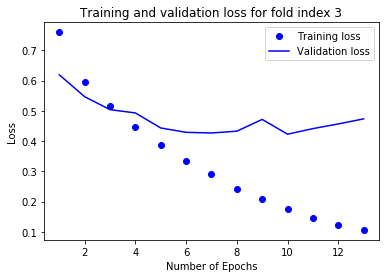

In [131]:
# Pass in a metric (without the `val_` prefix) and a fold index to show
# the training and validation error curves over the number of epochs
display_metric_vs_epochs_plot(all_scores, 'loss', 3)

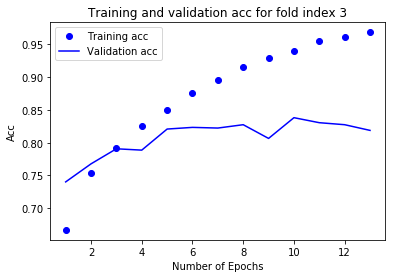

In [132]:
display_metric_vs_epochs_plot(all_scores, 'acc', 3)

### Make predictions on the test data
In order to make predictions on the Kaggle-provided unlabeled test data, we will need to submit our predictions to Kaggle. It would be best to train on the entire training set; this means that, this time, we won't provide a validation set to the Keras model.

How do we know how many epochs to train for? To figure this out, we can use the results from the cross validation phase. Since we have recorded the number of epochs that each fold took to train the model before stopping, we can take the average number of epochs across all folds and use that as the number of epochs to train our final model.

#### Calculate the number of epochs to train for using the entire training dataset

In [18]:
best_score_num_epochs

[2, 1]

In [19]:
# Let's take the average number of epochs across all folds.
final_num_epochs = np.mean(best_score_num_epochs)
# We take the ceiling because it's better to train for a little longer than to underfit.
final_num_epochs = np.ceil(final_num_epochs)
# We need to cast it to an int before feeding it to `model.fit`.
final_num_epochs = int(final_num_epochs)
final_num_epochs

2

#### Train the model

In [150]:
from models import build_cnn_model

In [31]:
# Build the embedding layer
embedding_layer = build_embedding_layer(embedding_matrix, 
                                        vocab_size, 
                                        EMBEDDING_DIM, 
                                        MAX_SEQUENCE_LENGTH)
# Build the model
model = build_cnn_model(embedding_layer, MAX_SEQUENCE_LENGTH)
# Save the model architecture, weights, and optimizer state to file
model.save(f'{OUTPUT_MODELS_DIR}final.model.hdf5')
# Save the model summary to file
save_model_summary(model, f'{OUTPUT_SUMMARIES_DIR}final.model_summary.txt')

In [22]:
# Train the model
history = model.fit(X_train_tokenized,
                    y_train_encoded,
                    batch_size=batch_size,
                    epochs=final_num_epochs,
                    verbose=1,
                    shuffle=True)

Epoch 1/2
19579/19579 [==============================] - 26s 1ms/step - loss: 0.8842 - acc: 0.5964
Epoch 2/2
19579/19579 [==============================] - 27s 1ms/step - loss: 0.6554 - acc: 0.7255


#### Make predictions on the test data

In [23]:
predictions = model.predict(X_test_tokenized, batch_size=batch_size, verbose=1)

8392/8392 [==============================] - 5s 619us/step


In [24]:
# Check the final submission values
predictions[0:3]

array([[0.03579558, 0.01009183, 0.9541125 ],
       [0.93095404, 0.06735893, 0.00168709],
       [0.00521636, 0.9862598 , 0.00852381]], dtype=float32)

#### Create a submission CSV

In [27]:
submission[['EAP', 'HPL', 'MWS']] = predictions
submission.to_csv(f'{SUBMISSIONS_DIR}001_submission.csv', index=False)

### Evaluate the average logloss of the Kaggle submission
After submitting to Kaggle, we can calculate the average logloss across the entire test dataset as follows:
```
Given:
    n_test = 8392
    %_private = 0.7
    %_public = 0.3
Average logloss = (private_logloss * n_private + public_logloss * n_public) / n_test
                = (private_logloss * (%_private * n_test)
                  + public_logloss * (%_public * n_test))
                  / n_test
Where n_test = n_private + n_public
```

## Refinement
Run random search to tune certain hyperparameters for each algorithm for at least 60 iterations (but I’ll lower that number if it ends up taking way too long) in order to find the best model.